In [6]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from calibration import lifetime_to_temperature_201112, pict_calibration
from scipy.optimize import curve_fit
import seaborn as sns
from PIL import Image
import scipy as sp
import cv2
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
#PATHの読み込み
intensity_path = []
lifetime_path = []
files = glob.glob('../Fig4/Fig4a/200919_IRheating_reconstruction_2_bin2/*')
files.sort()
for file in files:
    path = glob.glob(file + '/*ch00.tif')
    path.sort()
    intensity_path += path
    path = glob.glob(file + '/*ch01.tif')
    path.sort()
    lifetime_path += path

In [8]:
#IRレーザーがoffになるタイミングを探す
off_index = []
int_mean = []

for files in intensity_path:


    #加熱中心の強度変化
    int_image = np.array(Image.open(files))
    mean = np.mean(int_image)
    int_mean.append(mean)

diff = np.array(int_mean)[:-1] - np.array(int_mean)[1:]

#体裁調整
plt.figure(figsize = (12, 12))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams["font.size"] = 20

off_index = pd.DataFrame(diff)
off_index = np.ravel(off_index[off_index[0] > 1].index)

'''
plt.plot(diff)
plt.plot(int_mean)
plt.show()
'''

off_index_corrected = []
for index in off_index:
    max_index = pd.DataFrame(diff)[index - 5: index + 5][0].idxmax()
    off_index_corrected.append(max_index)
off_index_corrected = pd.DataFrame(off_index_corrected).drop_duplicates()[0]

<Figure size 864x864 with 0 Axes>

/var/folders/6w/hyvmhz8n61s0fqn11gs2dkfr0000gn/T/ipykernel_16894/1995368901.py:14: RuntimeWarning: invalid value encountered in true_divide
  lifetime_image = lifetime_image/intensity_image
/var/folders/6w/hyvmhz8n61s0fqn11gs2dkfr0000gn/T/ipykernel_16894/1995368901.py:14: RuntimeWarning: invalid value encountered in true_divide
  lifetime_image = lifetime_image/intensity_image
/var/folders/6w/hyvmhz8n61s0fqn11gs2dkfr0000gn/T/ipykernel_16894/1995368901.py:14: RuntimeWarning: invalid value encountered in true_divide
  lifetime_image = lifetime_image/intensity_image
/var/folders/6w/hyvmhz8n61s0fqn11gs2dkfr0000gn/T/ipykernel_16894/1995368901.py:14: RuntimeWarning: invalid value encountered in true_divide
  lifetime_image = lifetime_image/intensity_image
/var/folders/6w/hyvmhz8n61s0fqn11gs2dkfr0000gn/T/ipykernel_16894/1995368901.py:14: RuntimeWarning: invalid value encountered in true_divide
  lifetime_image = lifetime_image/intensity_image
/var/folders/6w/hyvmhz8n61s0fqn11gs2dkfr0000gn/T/i

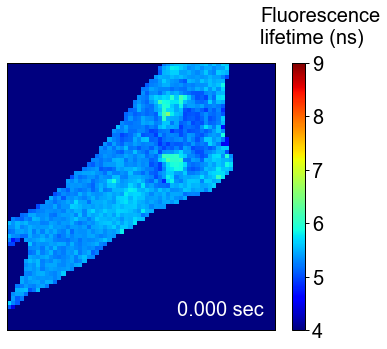

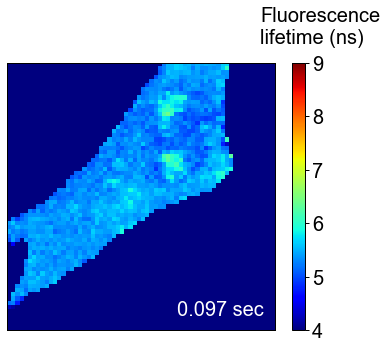

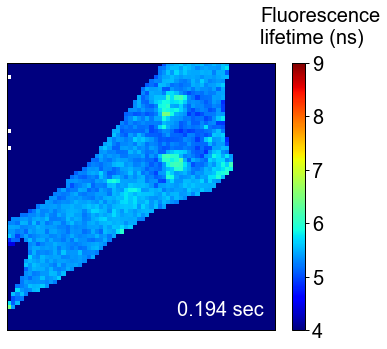

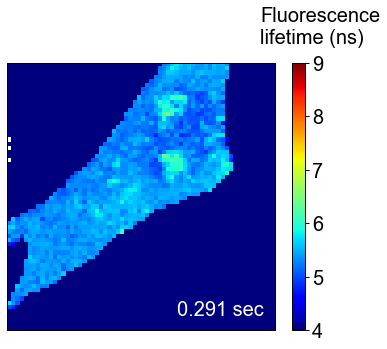

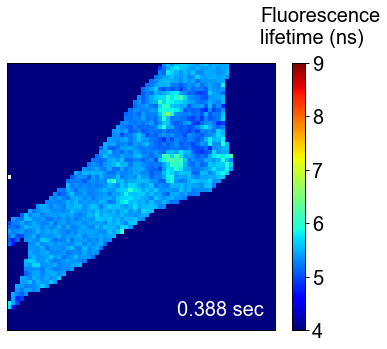

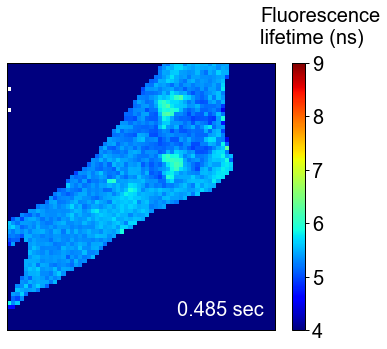

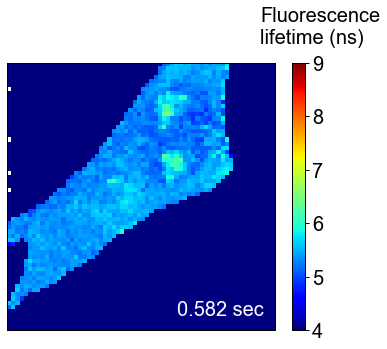

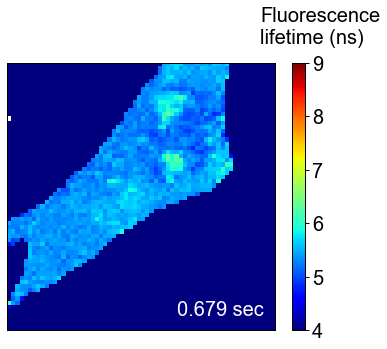

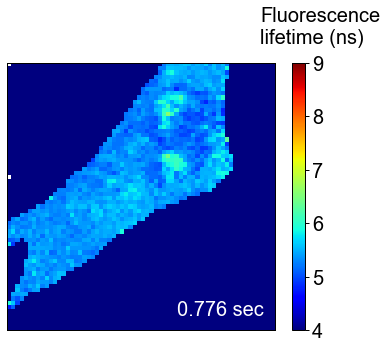

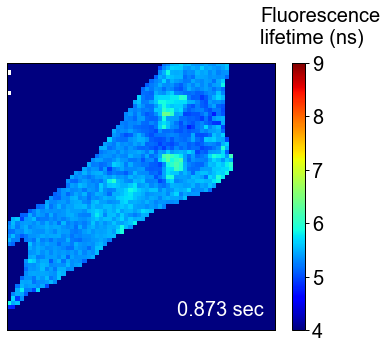

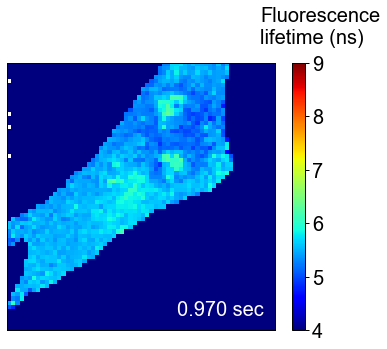

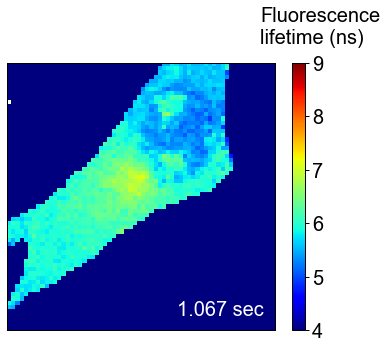

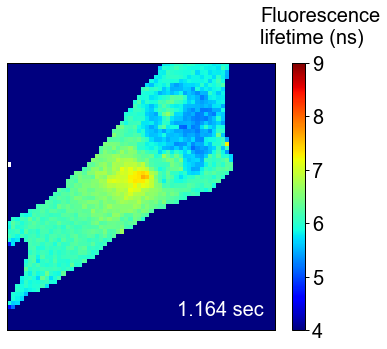

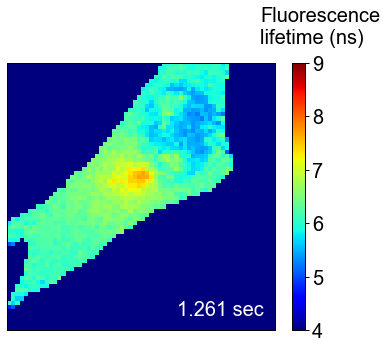

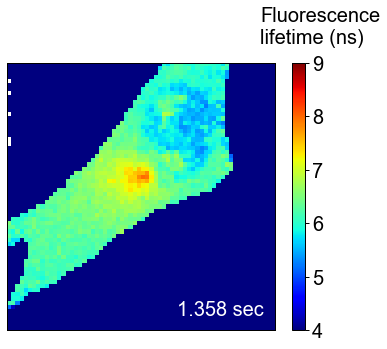

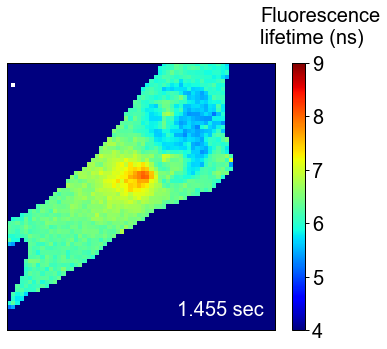

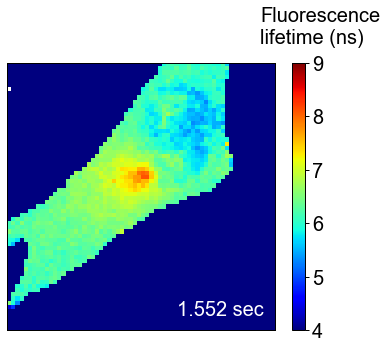

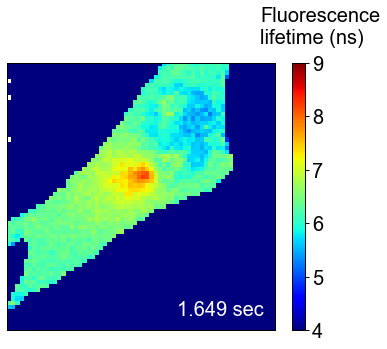

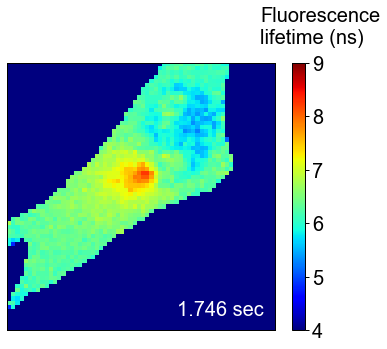

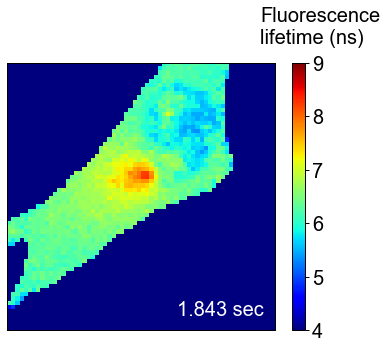

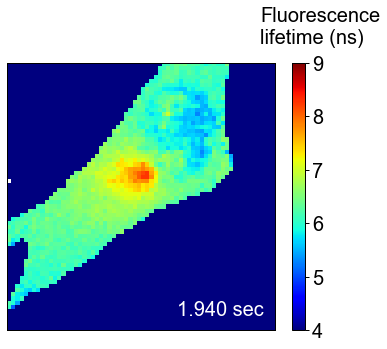

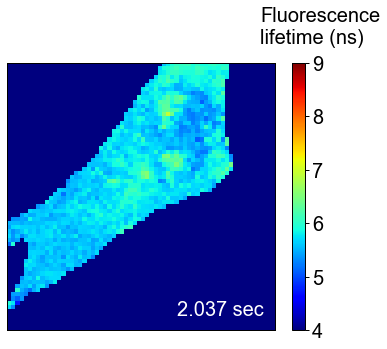

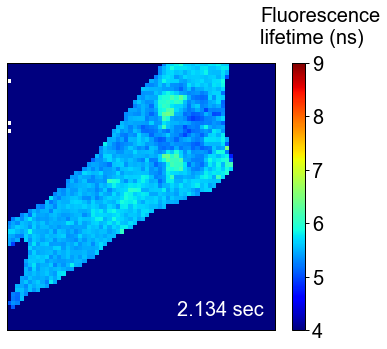

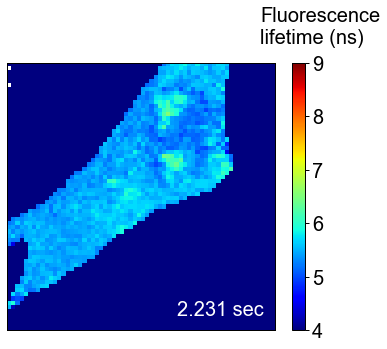

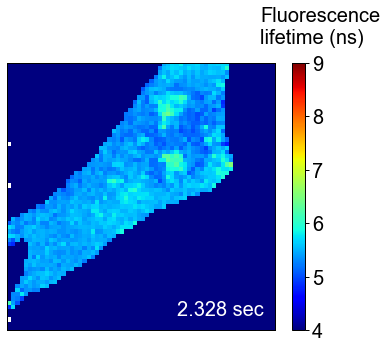

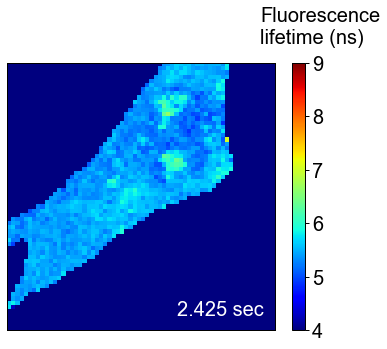

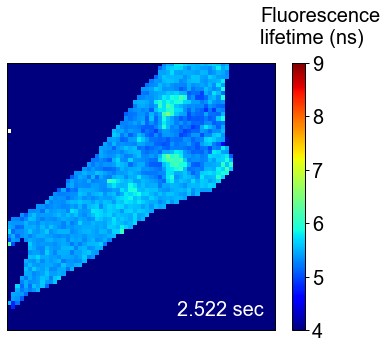

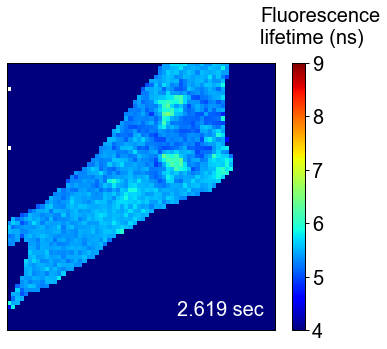

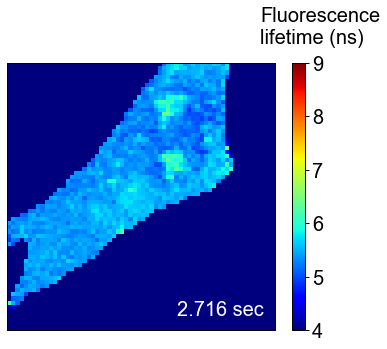

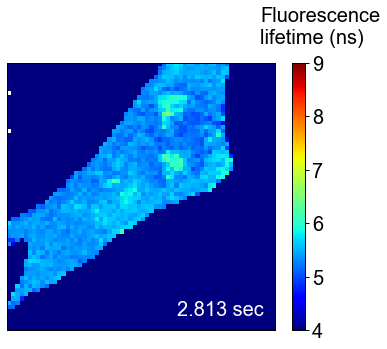

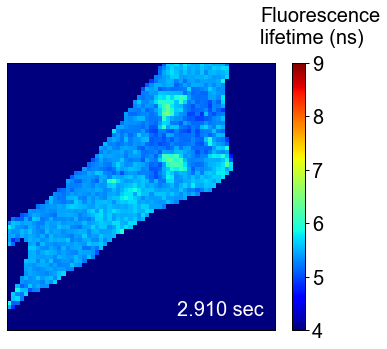

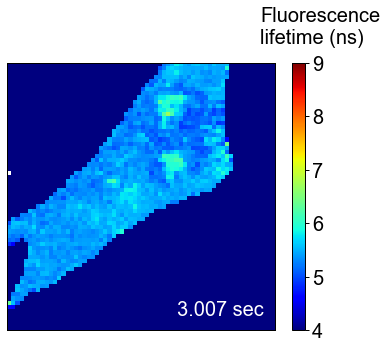

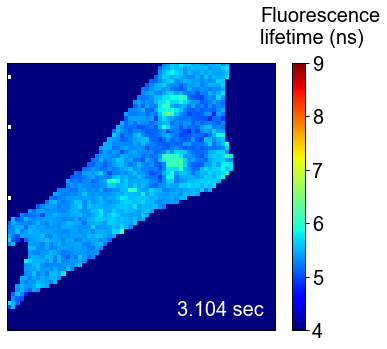

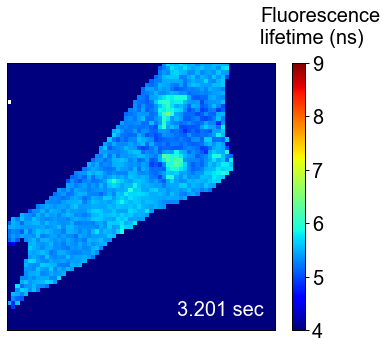

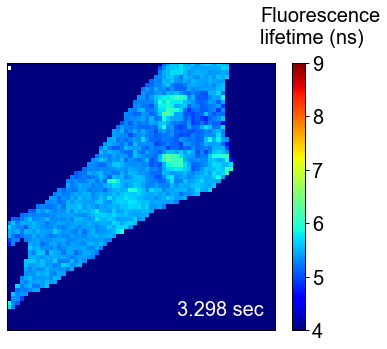

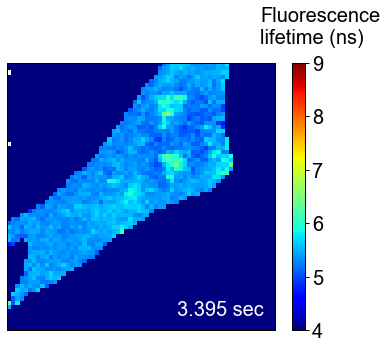

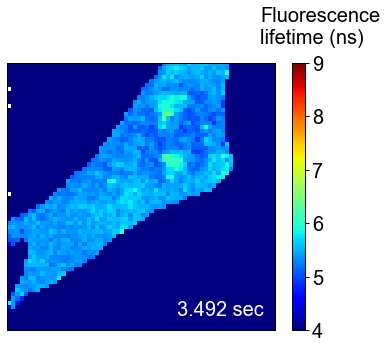

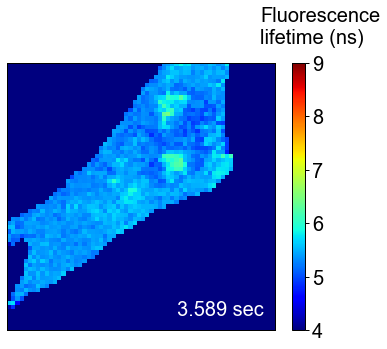

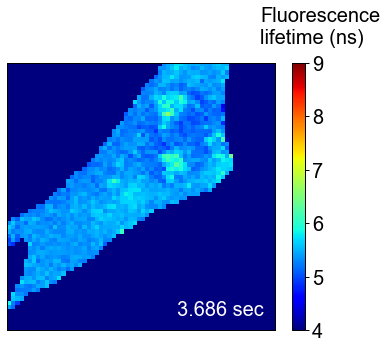

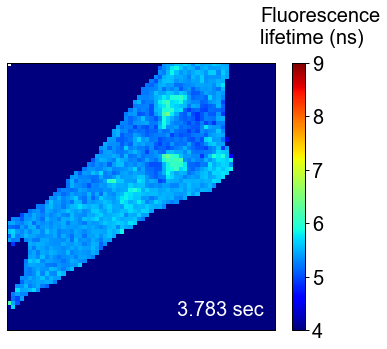

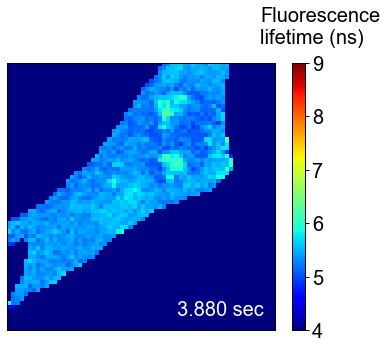

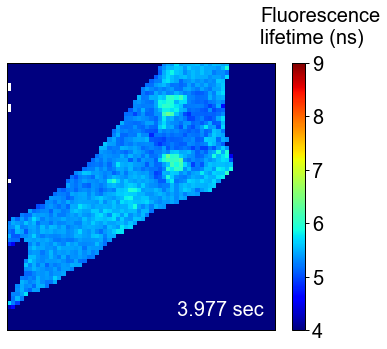

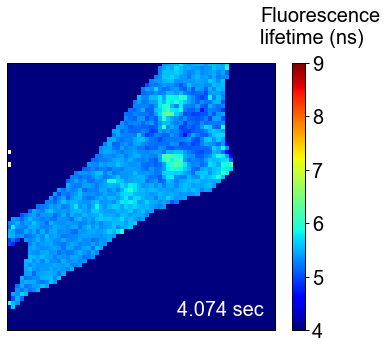

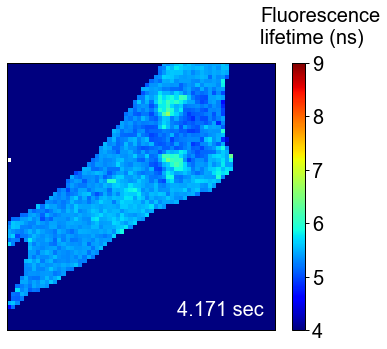

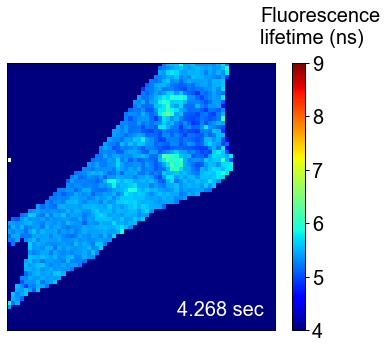

In [9]:
#細胞全体で温度の緩和を見る
frame = 1
mask = np.array(Image.open('../Fig4/Fig4a/masking.tif'))
mean_lifetime = []
for fix_time in range(-20, 25):
    lifetime_image = np.zeros((64, 64))
    intensity_image = np.zeros((64, 64))
    for index in off_index_corrected[:-1]:
        time = index + fix_time
        path_tmp_lifetime = lifetime_path[time]
        path_tmp_intensity = intensity_path[time]
        lifetime_image += np.array(Image.open(path_tmp_intensity))*(np.array(Image.open(path_tmp_lifetime))/1000)
        intensity_image += np.array(Image.open(path_tmp_intensity))
    lifetime_image = lifetime_image/intensity_image
    lifetime_image = lifetime_image*mask
    mean_lifetime.append(np.mean(lifetime_image[np.where(lifetime_image > 0)]))
    
    #体裁調整
    fig = plt.figure(figsize = (6, 6))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['xtick.major.width'] = 1.0
    plt.rcParams['ytick.major.width'] = 1.0
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams["font.size"] = 20
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    
    
    plt.imshow(lifetime_image, vmin = 4, vmax = 9, cmap = 'jet')
    plt.colorbar(shrink = 0.82)
    pp = PdfPages('../Program/Uneditied_figure/Fig4a_lifetime/'+ str(frame).zfill(3) + '.pdf')
    pp.savefig(fig)
    pp.close()
    
    time = 0.097*(frame-1)
    plt.text(60, -5, 'Fluorescence\nlifetime (ns)', color = 'black')
    plt.text(40, 60, str('{:.3f}'.format(time)) + ' sec', color = 'white')
    plt.savefig('../Program/Uneditied_figure/Fig4a_lifetime_jpg/'+ str(frame).zfill(3) + '.jpg')
    
    frame += 1

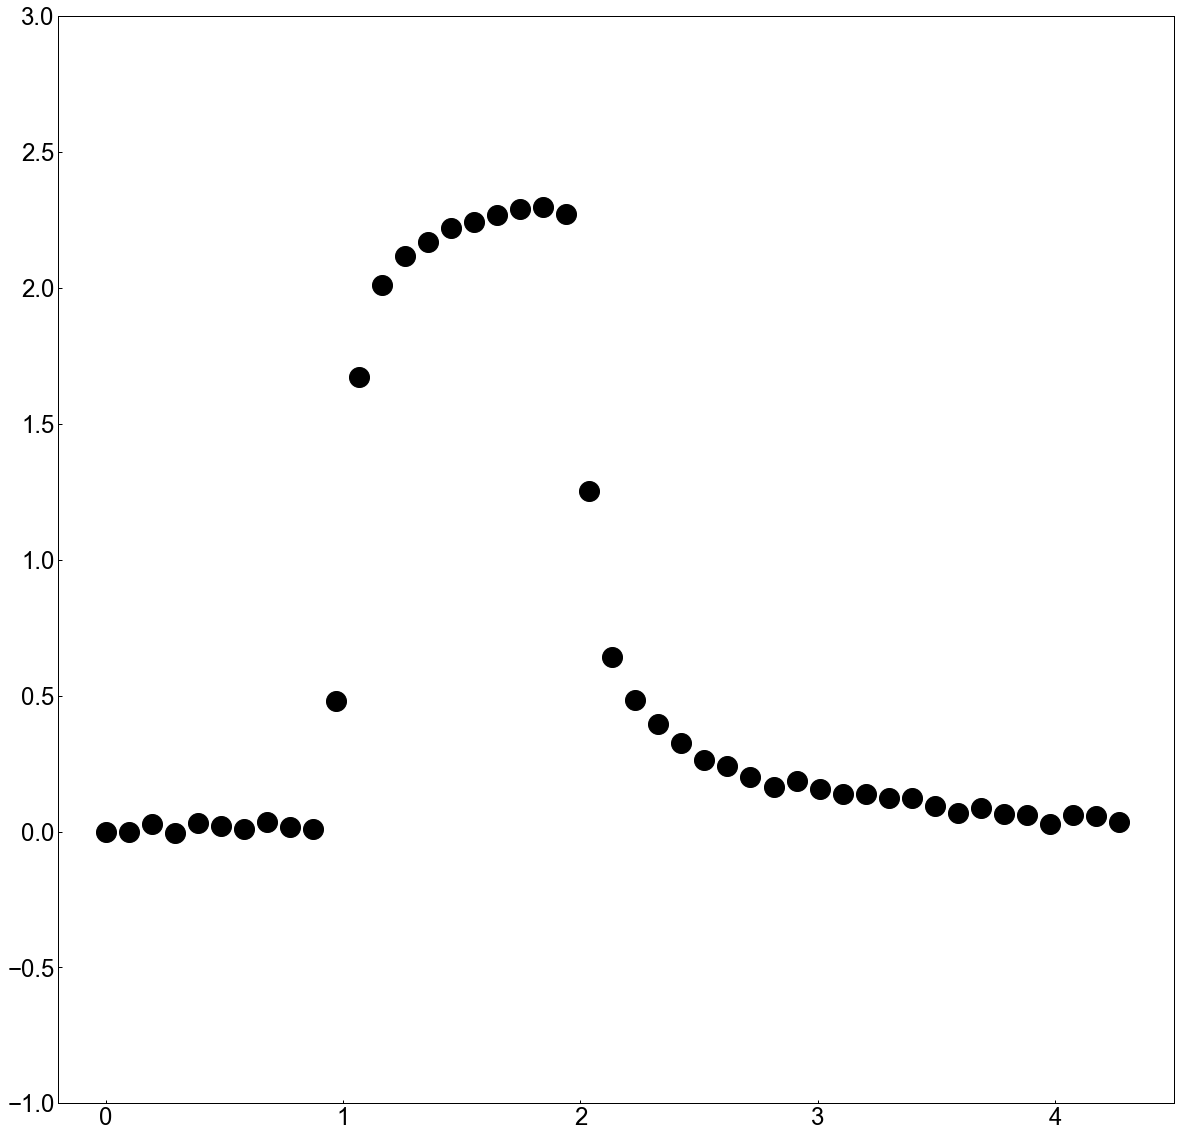

In [10]:
fig = plt.figure(figsize = (20, 20))
time = [0.097*i for i in range(len(mean_lifetime))]
mean_tmp = list(map(lifetime_to_temperature_201112, mean_lifetime))
plt.tick_params(axis='both', direction = "in", labelsize = 24)
plt.plot(time, mean_tmp-mean_tmp[0], color = 'black', linewidth = 0, marker = 'o', markersize = 20)
plt.ylim(-1, 3)
plt.xlim(-0.2, 4.5)
plt.show()

#pdfのセーブ
pp = PdfPages('../Program/Uneditied_figure/Fig4a_tmp.pdf')
pp.savefig(fig)
pp.close()

In [11]:
#動画に保存
img_array = []
for filename in sorted(glob.glob('../Program/Uneditied_figure/Fig4a_lifetime_jpg/*.jpg')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

name = '../supplementary_video/supplementary_video2.mov'
out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'mp4v'), 1/0.097, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()